# PROJET SVM-ANN : Marina Gourin et Julie Perron - M2 EKAP

#### Chargement des packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import string

In [2]:
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, r2_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import  TfidfTransformer, CountVectorizer

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.utils import tokenize

#### Importation des données

In [5]:
train = pd.read_csv("train.csv",
                    sep=",",header=0)

test = pd.read_csv("test.csv",
                    sep=",",header=0)  

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
train.shape

(12120, 6)

In [8]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [9]:
test.shape

(5195, 5)

In [10]:
train.language.unique()   

array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
       'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
       'Vietnamese', 'Spanish', 'Greek'], dtype=object)

In [11]:
train.groupby(['label']).count()

,id,premise,hypothesis,lang_abv,language
label,,,,,
0,4176,4176,4176,4176,4176
1,3880,3880,3880,3880,3880
2,4064,4064,4064,4064,4064


#### Visualisation des données

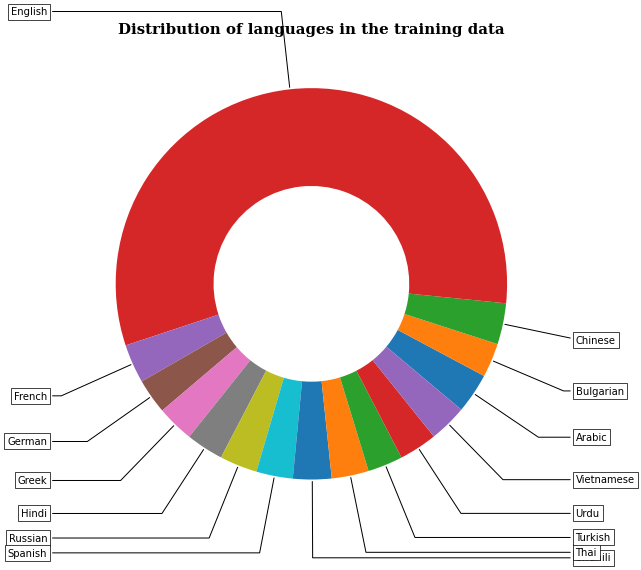

In [12]:
#Plotting the distribution of languages in the training data
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"))

languages, frequencies = np.unique(train.language.values, return_counts = True)

wedges, texts = ax.pie(frequencies, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(languages[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Distribution of languages in the training data",fontsize=15,family = 'serif',fontweight = 'bold')

plt.show()

##### Visualisation des modalités de la variable "label"

In [13]:
sntmnt=pd.DataFrame()
sntmnt['type']=train.label.value_counts().index
sntmnt['count']=train.label.value_counts().values
sntmnt

,type,count
0,0,4176
1,2,4064
2,1,3880


Text(0.5, 1.0, "Nombre d'observations dans chaque modalité de la variable 'label'")

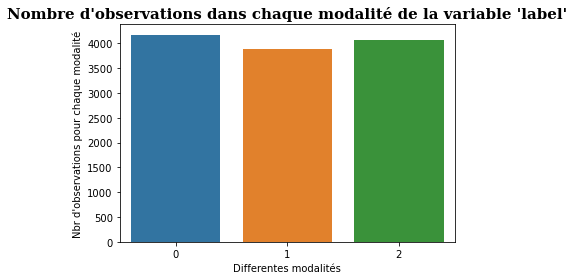

In [14]:
sns.countplot(train.label)
plt.xlabel('Differentes modalités')
plt.ylabel("Nbr d'observations pour chaque modalité")
plt.title("Nombre d'observations dans chaque modalité de la variable 'label'",
          fontsize=15,family = 'serif',fontweight = 'bold')

#### Création d'un sous-échantillon avec uniquement le language anglais

In [15]:
english_train = train[train['language'] == 'English']
english_train.shape

(6870, 6)

In [16]:
#Réindexation du dataframe
english_train.reset_index(drop = True, inplace = True)

In [17]:
english_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1


In [18]:
english_train['premise'].iloc[4]

"Look, it's your skin, but you're going to be in trouble if you don't get busy."

In [19]:
nltk.download('punkt')
word_tokenize(english_train['premise'].iloc[4])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Look',
 ',',
 'it',
 "'s",
 'your',
 'skin',
 ',',
 'but',
 'you',
 "'re",
 'going',
 'to',
 'be',
 'in',
 'trouble',
 'if',
 'you',
 'do',
 "n't",
 'get',
 'busy',
 '.']

##### Suppression des variables "language" et "lang_abv" dont on a plus besoin

In [20]:
english_train = english_train.drop(columns = ['lang_abv','language'])

In [21]:
english_train.head()

,id,premise,hypothesis,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


## Première approche

#### On compte le nombre de mot pour les variables "premise" et "hypothesis"

In [22]:
def word_count(dataset, column):
    len_vector = []
    for text in dataset[column]:
        len_vector.append(len(text.split()))
    
    return len_vector

In [23]:
english_train_premise = word_count(english_train, 'premise')
english_train_hypothesis = word_count(english_train, 'hypothesis')

##### Représentation graphique du nombre de mots

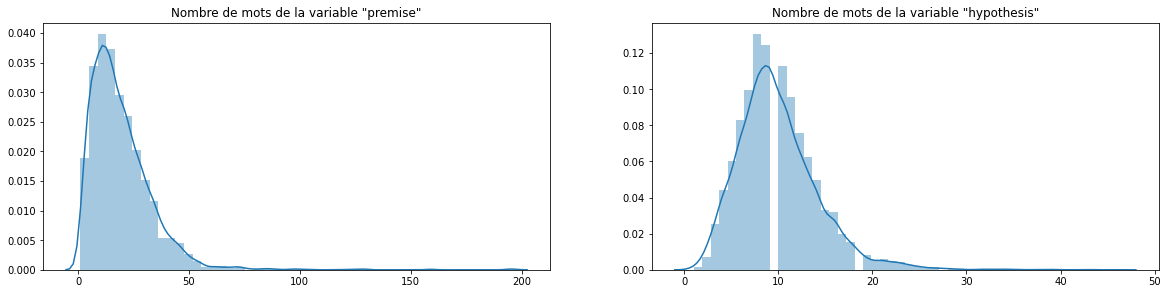

In [24]:
fig = plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
plt.title('Nombre de mots de la variable "premise"')
sns.distplot(english_train_premise)

plt.subplot(2,2,2)
plt.title('Nombre de mots de la variable "hypothesis"')
sns.distplot(english_train_hypothesis)
       
plt.show()

#### Création d'un nouveau dataFrame avec les nouvelles variables quantitatives

In [25]:
english_final_train = pd.DataFrame(english_train[['id','label']])
english_final_train['premise'] = english_train_premise
english_final_train['hypothesis'] = english_train_hypothesis

In [26]:
english_final_train.head()

,id,label,premise,hypothesis
0,5130fd2cb5,0,10,14
1,5b72532a0b,2,15,10
2,5622f0c60b,0,17,8
3,fdcd1bd867,2,7,7
4,7cfb3d272c,1,16,11


#### Préparation de Y et des variables explicatives 

In [27]:
Y= english_final_train['label']
X = english_final_train.drop(columns = ['label','id']).copy()

In [28]:
Y.value_counts()
Y.value_counts(normalize=True)
# répartition quasiement égale des modalités

0    0.353275
2    0.331441
1    0.315284
Name: label, dtype: float64

### Spécification des modèles

#### 1/ Arbre de décision

In [29]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X,Y)

DecisionTreeClassifier(random_state=0)

In [30]:
print("F1-score de l'échantillon train : {}".format(
    f1_score(Y,clf.predict(X), average="macro")
))

F1-score de l'échantillon train : 0.5046940227540541


En modifiant les paramètres de l'arbre de décision : 

In [31]:
clf = DecisionTreeClassifier(max_depth=300, min_samples_split=3,
                            class_weight="balanced",random_state=0)

clf.fit(X,Y)

print("F1-score de l'échantillon train  : {}".format(
    f1_score(Y,clf.predict(X), average="macro")
))

F1-score de l'échantillon train  : 0.5046666528103502


#### 2/ Random Forest

In [32]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X,Y)
print("F1-score de l'échantillon train  : {}".format(
    f1_score(Y,clf.predict(X), average="macro")
))

F1-score de l'échantillon train  : 0.5075956187895715


En changeant les paramètres de Random Forest :

In [33]:
clf = RandomForestClassifier(n_estimators=300, max_depth=60,
                             min_samples_split=3, class_weight='balanced',
                             random_state=0)

clf.fit(X,Y)

print("F1-score de l'échantillon train  : {}".format(
    f1_score(Y,clf.predict(X), average="macro")
))

F1-score de l'échantillon train  : 0.5067371201970416


#### 3/ Régression logistique

In [34]:
clf = LogisticRegression(solver='liblinear',random_state=0)
clf.fit(X,Y)
print("F1-score de l'échantillon train  : {}".format(
    f1_score(Y,clf.predict(X), average="macro")
))

F1-score de l'échantillon train  : 0.3557945366948674


On peut noter une très mauvaise prédiction. En effet, le score du modèle est seulement de 35.58%. Si l'on compare aux modèles précédents, il s'agit du plus mauvais en terme de score.

#### 4/ SVM linéaire

In [35]:
clf =svm.SVC(kernel='linear', C = 1.0)
model=clf.fit(X,Y)
print(model.score(X,Y))
svm_pred = clf.predict(X)
print(confusion_matrix(Y, svm_pred))

0.3553129548762737
[[2404   21    2]
 [2129   31    6]
 [2258   13    6]]


In [36]:
clf = svm.SVC(kernel='linear', C = 0.0001)
model=clf.fit(X,Y)
print(model.score(X,Y))
svm_pred = clf.predict(X)
print(confusion_matrix(Y, svm_pred))

0.3532751091703057
[[2427    0    0]
 [2166    0    0]
 [2277    0    0]]


#### 5/ SVM gaussien

In [37]:
clf = SVC(kernel="rbf", gamma="auto", C=1)
model=clf.fit(X,Y)
model.score(X,Y)

0.47438136826783117

In [38]:
clf = SVC(kernel="rbf", gamma="auto", C=1e6)
model=clf.fit(X,Y)
print(model.score(X,Y))
svm_pred = clf.predict(X)
print(confusion_matrix(Y, svm_pred))

0.5080058224163028
[[1306  436  685]
 [ 622  972  572]
 [ 669  396 1212]]


#### 6/ MLP Classifier

In [39]:
MLP_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model = MLP_classifier.fit(X, Y)
MLP_pred = MLP_classifier.predict(X)
model.score(X,Y)
print(confusion_matrix(Y, MLP_pred))

[[1079  517  831]
 [1034  554  578]
 [1006  387  884]]


## Deuxième approche

In [40]:
#Type de données
english_train.dtypes

id            object
premise       object
hypothesis    object
label          int64
dtype: object

In [41]:
#Changement du format des colonnes 'premise' et 'hypothesis' pour le fichier train
english_train2 = english_train.copy()
english_train2[['premise','hypothesis']] = english_train2[['premise','hypothesis']].astype(str)

#### Utilisation d'un système d'encodage

In [42]:
#Utilisation d'un label encoder
encoder=LabelEncoder()

In [43]:
#Encodage du fichier train
english_train2['code_premise'] = encoder.fit_transform(english_train2['premise'])
english_train2['code_hypothesis'] = encoder.fit_transform(english_train2['hypothesis'])
english_train2.head()

,id,premise,hypothesis,label,code_premise,code_hypothesis
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,2602,5228
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,2176,3399
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,3225,5839
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2,727,1082
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1,1298,4478


In [44]:
#Sélection des 150 premières lignes
eng_train = english_train2.iloc[:150]
eng_train.head()

,id,premise,hypothesis,label,code_premise,code_hypothesis
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,2602,5228
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,2176,3399
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,3225,5839
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2,727,1082
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1,1298,4478


In [45]:
#Création des X et Y
X = eng_train[['code_premise', 'code_hypothesis']].to_numpy()
y = eng_train['label'].to_numpy()

In [46]:
Y.value_counts()
Y.value_counts(normalize=True)
# répartition quasiement égale des modalités

0    0.353275
2    0.331441
1    0.315284
Name: label, dtype: float64

In [47]:
#Création des X_train, y_train, X_test et y_test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(105, 2)
(45, 2)
(105,)
(45,)


#### 1/ SVM linéaire avec les paramètres de défaut

In [48]:
# Classifieur- SVM linéaire avec paramètres de défaut
SVM_linear = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_linear.fit(X_train,y_train)

SVC(gamma='auto', kernel='linear')

In [49]:
#Prévisions
SVM_linear_pred = SVM_linear.predict(X_valid)

#Accuracy
print("Linear SVM Accuracy Score is :", round(accuracy_score(SVM_linear_pred, y_valid)*100,2),"%")

Linear SVM Accuracy Score is : 33.33 %


In [50]:
print(classification_report(y_valid, SVM_linear_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44        19
           1       0.25      0.08      0.12        13
           2       0.25      0.46      0.32        13

    accuracy                           0.33        45
   macro avg       0.32      0.32      0.30        45
weighted avg       0.34      0.33      0.32        45



#### 2/ SVM avec GridSearch

In [51]:
param_grid_rbf = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf','linear']} 

grid = GridSearchCV(SVC(), param_grid_rbf, refit = True)
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear']})

In [52]:
#Paramètres
print(grid.best_params_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [53]:
#Prédictions et Matrice de confusion
pred_grid = grid.predict(X_valid)
print(confusion_matrix(y_valid, pred_grid))

[[ 0  0 19]
 [ 0  0 13]
 [ 0  0 13]]


In [54]:
print(classification_report(y_valid, pred_grid,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        13
           2       0.29      1.00      0.45        13

    accuracy                           0.29        45
   macro avg       0.10      0.33      0.15        45
weighted avg       0.08      0.29      0.13        45



## Troisième approche 

In [55]:
#Création d'un nouveau dataframe et d'une nouvelle variable 'sentence'
english_train3 = english_train.copy()
english_train3['sentence'] = english_train3[['premise','hypothesis']].values.tolist()
english_train3['sentence'] = english_train3['sentence'].astype(str)
english_train3.head()

,id,premise,hypothesis,label,sentence
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,['and these comments were considered in formul...
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,['These are issues that we wrestle with in pra...
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,"[""you know they can't really defend themselves..."
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2,"[""From Cockpit Country to St. Ann's Bay"", ""Fro..."
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1,"[""Look, it's your skin, but you're going to be..."


In [56]:
#Création des X_train, y_train, X_test et y_test
X_train, X_valid, y_train, y_valid = train_test_split(english_train3[['sentence']], 
                                                      english_train3[['label']], test_size=0.30, random_state=42)

#### Utilisation de Word2vec

In [57]:
#pip install gensim

In [58]:
#Tokenization de la variable 'premise' de X_train
sentence = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentence']]
sentence[0]

['two',
 'is',
 'enough',
 'for',
 'a',
 'secret',
 'a',
 'secret',
 'needs',
 'two',
 'people']

In [59]:
#Spécification de Word2vec
word_model = word2vec.Word2Vec(sentence, size=300, window=20,
                          min_count=2, workers=1, iter=100)
word_model.corpus_count

4809

In [60]:
#Visualisation du corpus
vocab = word_model.wv.vocab
list(vocab)[:8]

['two', 'is', 'enough', 'for', 'a', 'secret', 'needs', 'people']

In [61]:
#Affichage des 5 premières coordonnées du vecteur asscoié au mot 'people'
word_model.wv['people'].shape, word_model.wv['people'][:5]

((300,),
 array([ 1.695151  , -4.144818  ,  2.3845334 ,  1.0439211 , -0.29039872],
       dtype=float32))

In [62]:
#Que se passe-t-il si un mot ne fait pas partie du corpus ?
try:
    word_model.wv['jeff']
except KeyError as error:
    print(error)

"word 'jeff' not in vocabulary"


In [63]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train['sentence'], word_model)
wv_train_feat.shape

(4809, 300)

#### 1/ Régression logistique

In [64]:
#Modélisation
reg_logistic = LogisticRegression(solver='lbfgs', max_iter=2000)
reg_logistic.fit(wv_train_feat, y_train.label)

LogisticRegression(max_iter=2000)

In [65]:
wv_test_feat = word2vec_features(X_valid["sentence"], word_model)

In [66]:
#Performance du modèle
reg_logistic.score(wv_test_feat, y_valid)

0.3182920912178554

## Quatrième approche

#### Combinaison du système d'encode et du comptage de mots

In [67]:
english_train4 = english_final_train.copy()
english_train4['code_premise'] = english_train2['code_premise']
english_train4['code_hypothesis'] = english_train2['code_hypothesis']

#### Sélection des 500 premières lignes :

In [68]:
english_train4 = english_train4.iloc[:500]
english_train4.head()

,id,label,premise,hypothesis,code_premise,code_hypothesis
0,5130fd2cb5,0,10,14,2602,5228
1,5b72532a0b,2,15,10,2176,3399
2,5622f0c60b,0,17,8,3225,5839
3,fdcd1bd867,2,7,7,727,1082
4,7cfb3d272c,1,16,11,1298,4478


#### Préparation de Y et des variables explicatives 

In [69]:
Y= english_train4['label']
X = english_train4.drop(columns = ['label','id']).copy()

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(350, 4)
(150, 4)
(350,)
(150,)


#### Spécification des modèles

##### 1/ Arbre de décision

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [72]:
print("F1-score de l'échantillon train : {}".format(
    f1_score(y_train,clf.predict(X_train), average="macro")
))
print("F1-score de l'échantillon validation : {}".format(
    f1_score(y_valid, clf.predict(X_valid), average='macro')
))

F1-score de l'échantillon train : 1.0
F1-score de l'échantillon validation : 0.3078938880825673


On observe un sur-apprentissage pour l'échantillon train puisque le score = 1. En modifiant les paramètres de l'arbre de décision : 

In [73]:
clf = DecisionTreeClassifier(max_depth=50, min_samples_split=4,
                            class_weight="balanced",criterion = 'entropy',random_state=0)

clf.fit(X_train,y_train)

print("F1-score de l'échantillon train  : {}".format(
    f1_score(y_train,clf.predict(X_train), average="macro")
))
print("F1-score de l'échantillon validation  : {}".format(
    f1_score(y_valid,clf.predict(X_valid), average="macro")
))

F1-score de l'échantillon train  : 0.9314986038390294
F1-score de l'échantillon validation  : 0.33362269560289365


Les performances du modèle n'ont presque pas augmenté par rapport au modèle précédent. Cependant, ce dernier est plsu robuste et nous avons diminué le sur-apprentissage.

##### 2/ Random Forest

In [74]:
clf = RandomForestClassifier(random_state=0)

clf.fit(X_train,y_train)

print("F1-score de l'échantillon train  : {}".format(
    f1_score(y_train,clf.predict(X_train), average="macro")
))
print("F1-score de l'échantillon validation  : {}".format(
    f1_score(y_valid,clf.predict(X_valid), average="macro")
))

F1-score de l'échantillon train  : 1.0
F1-score de l'échantillon validation  : 0.3199429600018701


Nous sommes toujours confrontées à un problème de sur-apprentissage. De plus, ce modèle est moins performant sur l'échantillon de validation que le premier. Nous allons le faire évoluer en changeant les paramètres de Random Forest :

In [75]:
clf = RandomForestClassifier(n_estimators=100, max_depth=6,
                             min_samples_split=4, criterion = 'entropy',class_weight='balanced',
                             random_state=0)

clf.fit(X_train,y_train)

print("F1-score de l'échantillon train  : {}".format(
    f1_score(y_train,clf.predict(X_train), average="macro")
))
print("F1-score de l'échantillon validation  : {}".format(
    f1_score(y_valid,clf.predict(X_valid), average="macro")
))

F1-score de l'échantillon train  : 0.8207167325428196
F1-score de l'échantillon validation  : 0.33942229880962627


Nous pouvons noter une légère amélioration du modèle avec un Fscore de 33% pour l'échantillon validation.

##### 3/ Régression logistique

In [76]:
clf = LogisticRegression(solver='liblinear',random_state=0)

clf.fit(X_train,y_train)
print("F1-score de l'échantillon train  : {}".format(
    f1_score(y_train,clf.predict(X_train), average="macro")
))
print("F1-score de l'échantillon validation  : {}".format(
    f1_score(y_valid,clf.predict(X_valid), average="macro")
))

F1-score de l'échantillon train  : 0.4352171564285045
F1-score de l'échantillon validation  : 0.3731030873888017


##### 4/ SVM linéaire

In [77]:
clf =svm.SVC(kernel='linear', C = 1.0)
model=clf.fit(X_train,y_train)

In [78]:
print(model.score(X_train,y_train))
svm_pred = clf.predict(X_valid)
print(confusion_matrix(y_valid, svm_pred))

0.38
[[12 33  7]
 [10 33  7]
 [ 5 31 12]]


In [79]:
#Accuracy
print("Linear SVM Accuracy Score is :", round(accuracy_score(svm_pred, y_valid)*100,2),"%")

Linear SVM Accuracy Score is : 38.0 %


Nous allons changer la valeur de C dans le modèle précédent :

In [80]:
clf2 = svm.SVC(kernel='linear', C = 0.1)
model2 = clf2.fit(X_train,y_train)
print(model2.score(X_train,y_train))

svm_pred2 = clf2.predict(X_valid)
print(confusion_matrix(y_valid, svm_pred2))

print("Linear SVM Accuracy Score is :", round(accuracy_score(svm_pred2, y_valid)*100,2),"%")

0.43142857142857144
[[18 13 21]
 [19 17 14]
 [12 13 23]]
Linear SVM Accuracy Score is : 38.67 %


In [81]:
cv_results = cross_val_score(clf2, X_valid, y_valid, cv=2)
moyenne_cv_results = cv_results.mean()
print("Taux de prédiction trouvés : {}" .format(cv_results))
print("Taux de prédiction de Cross-Validation (moyenne) : {}" .format(moyenne_cv_results))

Taux de prédiction trouvés : [0.30666667 0.36      ]
Taux de prédiction de Cross-Validation (moyenne) : 0.3333333333333333


##### 5/ SVM gaussien

In [82]:
clf3 = svm.SVC(kernel="rbf")
model3=clf3.fit(X_train,y_train)
print(model3.score(X_train,y_train))

svm_pred3 = clf3.predict(X_valid)
print(confusion_matrix(y_valid, svm_pred3))

0.39714285714285713
[[31 15  6]
 [30 18  2]
 [24 20  4]]


In [83]:
#Accuracy
print("SVM Gaussian Accuracy Score is :", round(accuracy_score(svm_pred3, y_valid)*100,2),"%")

SVM Gaussian Accuracy Score is : 35.33 %


Nous allons changer la valeur de C dans le modèle précédent :

In [84]:
clf4 = svm.SVC(kernel="rbf", gamma="auto", degree=2, C=0.1)
model4 = clf4.fit(X_train,y_train)
print(model4.score(X_train,y_train))

svm_pred4 = clf4.predict(X_valid)
print(confusion_matrix(y_valid, svm_pred4))

0.34285714285714286
[[52  0  0]
 [50  0  0]
 [48  0  0]]


In [85]:
#Accuracy
print("SVM Gaussian Accuracy Score is :", round(accuracy_score(svm_pred4, y_valid)*100,2),"%")

SVM Gaussian Accuracy Score is : 34.67 %


##### 6/ MLP Classifier

In [86]:
MLP_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model = MLP_classifier.fit(X_train, y_train)
print(model.score(X_train,y_train))

MLP_pred = MLP_classifier.predict(X_valid)
print(confusion_matrix(y_valid, MLP_pred))

0.34285714285714286
[[52  0  0]
 [50  0  0]
 [48  0  0]]


In [87]:
#Accuracy
print("MPL classifier Accuracy Score is :", round(accuracy_score(MLP_pred, y_valid)*100,2),"%")

MPL classifier Accuracy Score is : 34.67 %


##### 7/ Optimisation avec GridSearch

In [88]:
n_estimators = [5,10,20,40,80,100,150,200,400]
max_depth = [5, 10, 20, 30, 50]
#min_samples_split = [0.1, 0.05, 0.03, 2]
#class_weight = [None, "balanced"]

parameters = {'n_estimators': n_estimators ,
              'max_depth' : max_depth
#              'min_samples_split' : min_samples_split
#              'class_weight' : class_weight
             }

RF = RandomForestClassifier()

clf = GridSearchCV(RF, parameters, scoring = 'f1_macro', cv = 5 )
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20, 30, 50],
                         'n_estimators': [5, 10, 20, 40, 80, 100, 150, 200,
                                          400]},
             scoring='f1_macro')

In [89]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [90]:
gridsearch_result = pd.DataFrame(clf.cv_results_["params"])
gridsearch_result["score"] = clf.cv_results_["mean_test_score"]

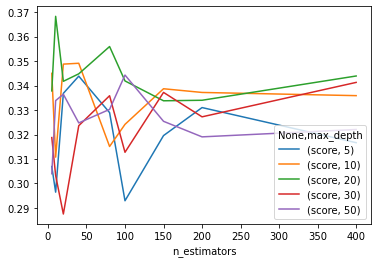

In [91]:
gridsearch_result[["n_estimators","max_depth","score"]].groupby(["n_estimators","max_depth"]).mean().unstack().plot()
plt.show()

In [92]:
clf_final = clf.best_estimator_
print(clf_final.set_params)

<bound method BaseEstimator.set_params of RandomForestClassifier(max_depth=20, n_estimators=10)>


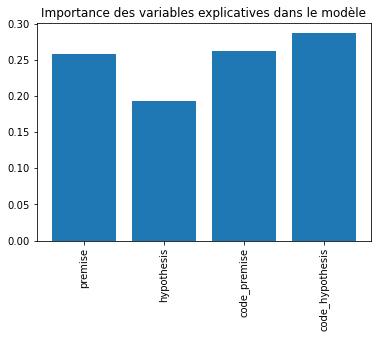

In [93]:
var_explicative = list(X)
plt.bar(
    var_explicative,
    clf_final.feature_importances_
)
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives dans le modèle")
plt.show()

In [94]:
print("Valid F1-score : {}".format(
    f1_score(y_valid, clf_final.predict(X_valid), average='macro')
))

Valid F1-score : 0.34640538642564983


##### 8/ Tensorflow

In [95]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(10),
])

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 0s 2ms/step - loss: 180.9570 - accuracy: 0.3229
Epoch 2/10
11/11 [==============================] - 0s 722us/step - loss: 77.5493 - accuracy: 0.3457
Epoch 3/10
11/11 [==============================] - 0s 635us/step - loss: 42.7200 - accuracy: 0.3286
Epoch 4/10
11/11 [==============================] - 0s 816us/step - loss: 25.0222 - accuracy: 0.3229
Epoch 5/10
11/11 [==============================] - 0s 725us/step - loss: 20.1195 - accuracy: 0.3486
Epoch 6/10
11/11 [==============================] - 0s 725us/step - loss: 11.4890 - accuracy: 0.3257
Epoch 7/10
11/11 [==============================] - 0s 907us/step - loss: 6.3552 - accuracy: 0.3714
Epoch 8/10
11/11 [==============================] - 0s 725us/step - loss: 4.8091 - accuracy: 0.3800
Epoch 9/10
11/11 [==============================] - 0s 816us/step - loss: 4.4851 - accuracy: 0.3800
Epoch 10/10
11/11 [==============================] - 0s 816us/step - loss: 5.0503 - accuracy: 0

In [98]:
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)
print('\nTest accuracy:', round(test_acc,4))

5/5 - 0s - loss: 6.3825 - accuracy: 0.3133

Test accuracy: 0.3133


In [99]:
#Prévision
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_valid)
predictions[0]

array([9.9991238e-01, 8.7962265e-10, 8.7620567e-05, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

## Cinquième approche 

Dans cette nouvelle approche, nous allons nous concentrer sur la classification des 'contradictions'

In [100]:
#Création d'une nouvelle 'target'
#On veut essayer de savoir si 'premise' et 'hypothesis' sont des contractions ou non

english_train5 = english_train.copy()
english_train5['contradiction'] = np.where(english_train5['label']==2, 1, 0)
english_train5.head()

,id,premise,hypothesis,label,contradiction
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,1
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,0
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2,1
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1,0


Sélection des 1000 premières lignes :

In [101]:
english_train5 = english_train5.iloc[:1000]
english_train5.head()

,id,premise,hypothesis,label,contradiction
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,0,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2,1
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0,0
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2,1
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1,0


In [102]:
X=english_train5['premise']+english_train5['hypothesis']
y=english_train5['contradiction'].values
y=np.array(y)

#### Utilisation de CountVectorizer

In [103]:
cv=CountVectorizer(stop_words='english')

In [104]:
X=cv.fit_transform(X)

In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.3,random_state=42)

##### 1/ SVM linéaire

In [106]:
lin_SVM = svm.SVC(kernel='linear')
lin_SVM_fit = lin_SVM.fit(X_train, y_train)

lin_pred = lin_SVM.predict(X_valid)
print(metrics.classification_report(lin_pred, y_valid))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       201
           1       0.27      0.24      0.26        99

    accuracy                           0.53       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.52      0.53      0.53       300



##### 2/ SVM avec GridSearch

In [107]:
grid = {
'C': [0.1, 1, 10, 100, 1000],
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'kernel': ['rbf','linear']}

SVM_rbf = svm.SVC()
grid_search = GridSearchCV(SVM_rbf, param_grid = grid, refit = True)
grid_search_fit = grid_search.fit(X_train, y_train)
SVM_rbf_pred = grid_search.predict(X_valid)
print(metrics.classification_report(SVM_rbf_pred, y_valid,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83       300
           1       0.00      0.00      0.00         0

    accuracy                           0.70       300
   macro avg       0.50      0.35      0.41       300
weighted avg       1.00      0.70      0.83       300



#### Utilisation d'un pipeline

##### 1/ SVM linéaire

In [108]:
#Spécification du pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', svm.SVC(kernel='linear')),
])

In [109]:
#Echantillonnage du jeu de données 
X=english_train5['premise']+english_train5['hypothesis']
y=english_train5['contradiction'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
pip_fit = pipeline.fit(X_train,y_train)

In [111]:
pip_pred = pip_fit.predict(X_valid)

In [112]:
print(classification_report(y_valid,pip_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       211
           1       0.29      0.11      0.16        89

    accuracy                           0.65       300
   macro avg       0.49      0.50      0.47       300
weighted avg       0.58      0.65      0.60       300



##### 2/ SVM avec GridSearch

In [113]:
#Spécification de GridSearch
grid = {
'C': [0.1, 1, 10, 100, 1000],
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'kernel': ['rbf','linear']}

SVM_rbf = svm.SVC()
grid_search = GridSearchCV(SVM_rbf, param_grid = grid, refit = True)

In [114]:
#Spécification du pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', grid_search),
])

In [115]:
grid_search_fit = pipeline.fit(X_train, y_train)
SVM_rbf_pred = pipeline.predict(X_valid)
print(metrics.classification_report(SVM_rbf_pred, y_valid,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83       300
           1       0.00      0.00      0.00         0

    accuracy                           0.70       300
   macro avg       0.50      0.35      0.41       300
weighted avg       1.00      0.70      0.83       300

